# BASICS OF MOBILE ROBOTICS
## BOMR Project

This project was made by the Group 31, made up of the following people:

### Axel Béguelin, Lou De Bel-Air, Robin Carlet, Robin Junod.

For this project of mobile robotics, we were asked to use a Thymio II robot, a camera and our project had to use the following concepts:

- Vision
- Global Navigation
- Motion Control
- Filtering
- Local Navigation

Just a quick resume of the robot. Thymio II is an educational robot in the 100 Euros price range. The robot was developed at the EPFL in collaboration with ECAL, both in Lausanne, Switzerland (wiki source). This robot has the following features:

- 2 DC-motors (and 2 Wheels)
- 39 leds
- 1 loud speaker

and has the following sensors:
- 9 infrared (IR) proximity sensors (reach about 10cm)
- 5 capacitive touch buttons
- 1 three-axis accelerometer
- 1 thermometer
- 1 microphone (recording or detection of noise)
- 1 IR receiver (for remote controller)
- 1 Wireless module

![SNOWFALL](img_presentation/img_thymio.png)

# Introduction of our project

The goal is that the Thymio can go from any position on a map to an objective. 
We decided to approch this project with the following setup :
<div>
<img src="img_presentation/Setup.jpeg" width="300"/>
</div>

A camera placed above the installation allows to visualize the map on the computer. It identifies the Thymio, the obstacles and the goal. 
Then the global navigation computes the shortest path to the goal, and the motion control adjusts the motor speeds to follow it.

To have a more precise trajectory and to counteract uncertainties, there is a feedback on the robot's position, which will pass through a Bayesian filter.

The location of the obstacles, the goal and the initial position of the Thymio can be modified before the execution of the code.
Even if new obstacles are added to the terrain after the code execution, the robot is able to reach the goal by avoiding them using local navigation. We also want the robot to reach the goal even if it is "kidnapped".

To facilitate the identification of the different objects by computer vision, we used different colors and shapes. The goal (red) and the obstacles (blue) for the global navigation are in two dimensions. The two green dots on the Thymio allow to know its angle and its position on the map.

The obstacles for local navigation are three-dimensional, so that they can be detected by the horizontal proximity sensors.

Each module as well as their sharing will be developed in the following sections.


# 1. Vision
A webcam, looking at the map from the top, is used to create a map of the environment and to localize the Thymio. The vision is used first to initialize the map (locate each obstacle, the goal, as well as the position of the thymio on the map) and consecutively to locate the thymio during its journey in order to allow the filtering of its metrics. 
### 1.1 Method
Each module is demonstrated on a recorded image taken by the webcam. The image can be loaded and displayed by running the code below and will then be used in each sub-section.

Text(0.5, 1.0, 'Raw picture of the map')

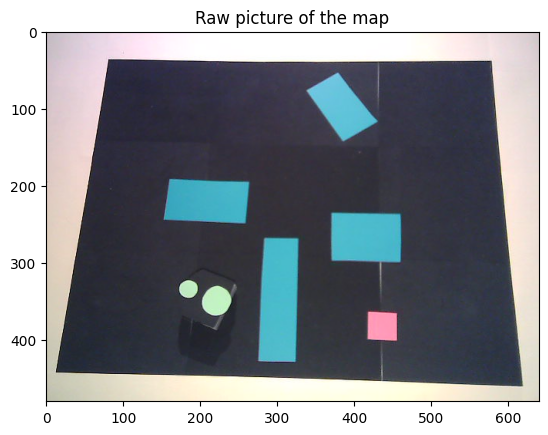

In [1]:
import function.vision as vision
import cv2
import numpy as np
import math as m
#%matplotlib notebook 
import matplotlib.pyplot as plt

#%matplotlib notebook
img_name = 'img_presentation/Calibration_1012_1.png'
img = cv2.imread(img_name, cv2.IMREAD_COLOR)
plt.figure()
plt.imshow(img[:,:,::-1])
plt.title('Raw picture of the map')

Since the images taken by the webcam are distorted due to perspective, each time the webcam takes a picture, the first step is to rectify and crop the image before finding the position of the elements. To do this, a color filter is first applied to the image to amplify the difference between the yellow frame and the black ground. The image is then filtered using a bilateral filter to remove noise and finally thresholding is applied. The function findContours from open CV is then used to extract the edges of the map, followed by approxPolyDP which gives the corners. The perspective transformation can be then performed. The rectified map is generated when the next cell is executed.  
 

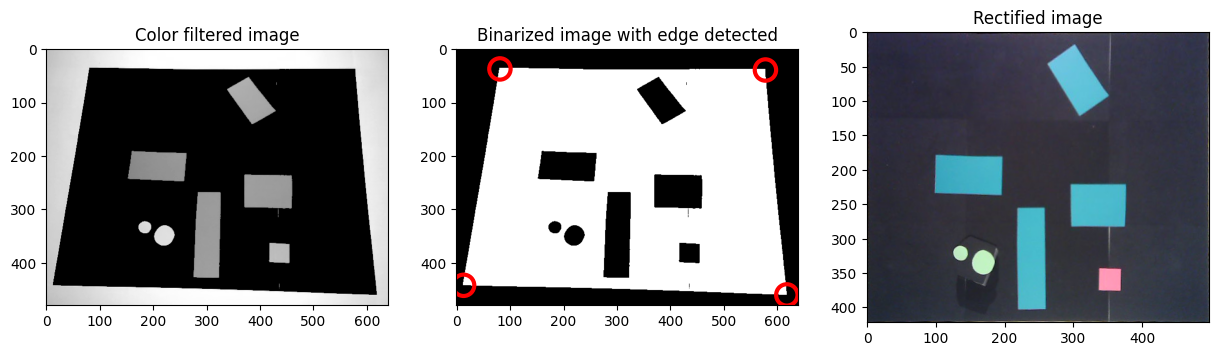

In [2]:
# Map tranform function
hsv, mask, field = vision.colorFilter(img, vision.YELLOW_L, vision.YELLOW_H)

field_gray = cv2.cvtColor(field, cv2.COLOR_BGR2GRAY)
# noise
filtered_img = cv2.bilateralFilter(field_gray,3,75,75)
# binary
binary_img = cv2.threshold(filtered_img, 20, 255, cv2.THRESH_BINARY_INV)[1]

# find contours of MAP
contours, _ = cv2.findContours(binary_img.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
approx_cont = []

for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 0.03*cv2.arcLength(cnt, True), True)
    area = cv2.contourArea(approx)
    # Criteria on the area to get only the external frame and not the obstacle or thymio if color filter did not work fine
    if (binary_img.shape[0]*binary_img.shape[1]/2 < area < binary_img.shape[0]*binary_img.shape[1]):
        approx_cont.append(approx.reshape(-1, 2))          

# Correction of the perspective
# First find the corners and figure out which one is which (top left / top right etc.)
corners_tmp = approx_cont[0]
corners_sorted = corners_tmp[corners_tmp[:, 1].argsort()]
corners_top = corners_sorted[0:2,:]
C_top_left = corners_top[corners_top[:, 0].argsort()][0,:]
C_top_right = corners_top[corners_top[:, 0].argsort()][1,:]
corners_bot = corners_sorted[2:,:]
C_bot_left = corners_bot[corners_bot[:, 0].argsort()][0,:]
C_bot_right = corners_bot[corners_bot[:, 0].argsort()][1,:]
pts1 = np.float32([C_top_left, C_bot_left, C_bot_right, C_top_right])
#Target Points
t1 = pts1[0,0] #corner top left
t2 = pts1[0,1]
r1 = pts1[3,0] #corner top right
r2 = pts1[3,1]
b1 = pts1[2,0] #corner bottom right
b2 = pts1[2,1]
width = m.floor(m.sqrt((r1 - t1) ** 2 + (r2 - t2) ** 2))
height = m.floor(m.sqrt((b1 - r1) ** 2 + (b2 - r2) ** 2))
pts2 = np.float32([[0, 0], [0, height], [width, height], [width, 0]])
M = cv2.getPerspectiveTransform(pts1.astype(np.float32), pts2)
dst = cv2.warpPerspective(img, M, (width, height))

## Rescaling image (between width and height)
recMap = dst[0:height, 0:width]
## Plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,8))
ax1.imshow(filtered_img, cmap='gray')
ax2.imshow(binary_img, cmap='gray')
ax3.imshow(recMap[:,:,::-1])
ax1.set_title('Color filtered image')
ax2.set_title('Binarized image with edge detected')
ax3.set_title('Rectified image')
for edge in approx_cont[0]:
    circle = plt.Circle(edge, 20, color='r', fill=False, linewidth=3)
    ax2.add_patch(circle)

Since the webcam always takes picture from the same perspective, the output parameters "M", "width" and "height" of the mapTransform function are used later to rectify the map without having to find the map corners again. The width is also used to compute the pixel to millimeter ratio, which is used in motion control and in global navigation. 
Finally, to eliminate small imperfections on the edges of the image and as a "safety factor" for path planning, the map is cropped by 10 pixels on each side:

Text(0.5, 1.0, 'Rectified picture of the map')

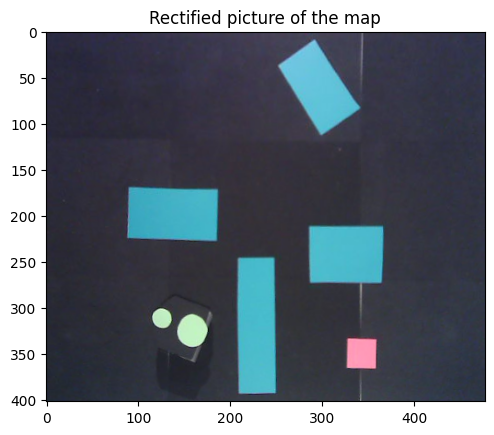

In [3]:
vision.mm2pixRatio(recMap)
rescMap = vision.rescale_borders(recMap)
plt.figure()
plt.imshow(rescMap[:,:,::-1])
plt.title('Rectified picture of the map')

The map is now ready for the location of the objective, the obstacles and the thymio.
In order to simplify the localization of each element of the map, it was decided to assign them different colors:
- Thymio : Green
- Obstacles : Blue
- Goal : Red

For each element, the first step is to isolate it from the others by color filtering using the cv2.InRange(image,Threshold) function on an HSV image of the map. In order to find the right threshold for each color, a tool from: https://stackoverflow.com/questions/57469394/opencv-choosing-hsv-thresholds-for-color-filtering was used. The code below shows the color filtering process on the image that was used to find the threshold. Small pieces of green, blue and red paper were placed on the map at different locations and the threshold was found using the tool mentioned above. It was important not to place a single piece of paper in the middle of the map because of the lighting condition which can vary across the map and lead to different thresholds depending on location.

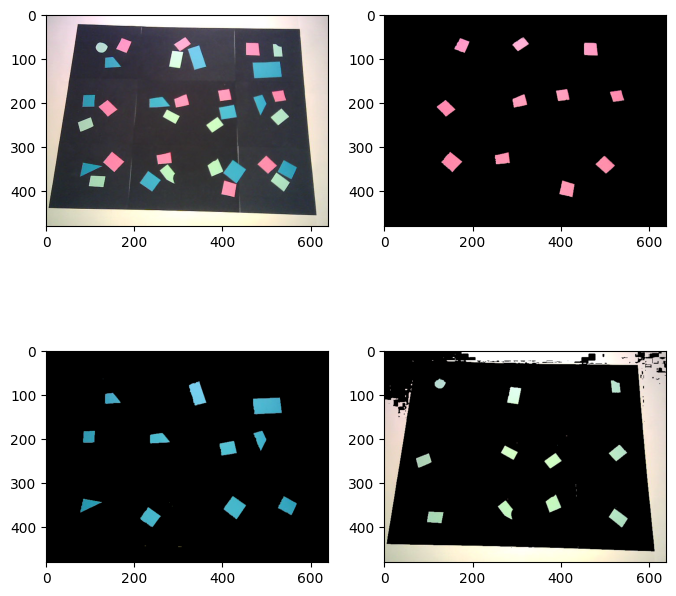

In [4]:
img_name = 'img_presentation/Calibration_Colors.png'
img_color = cv2.imread(img_name, cv2.IMREAD_COLOR)
_, _, red = vision.colorFilter(img_color,vision.RED_L, vision.RED_H)
_, _, blue = vision.colorFilter(img_color,vision.BLUE_L, vision.BLUE_H)
_, _, green = vision.colorFilter(img_color,vision.GREEN_L, vision.GREEN_H)

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (8,8))
ax1.imshow(img_color[:,:,::-1])
ax2.imshow(red[:,:,::-1])
ax3.imshow(blue[:,:,::-1])
ax4.imshow(green[:,:,::-1])

The different techniques used to extract the coordinates of each element on the map are presented in the next sub-chapter.
### 1.2 Find goal coordinates
After a red filtering of the rescaled map, the image is binarized and the goal is found using the function moments from openCV. This makes it easy to find the center of the red rectangle, as shown in the following cell execution.

Text(0.5, 1.0, 'Goal detected')

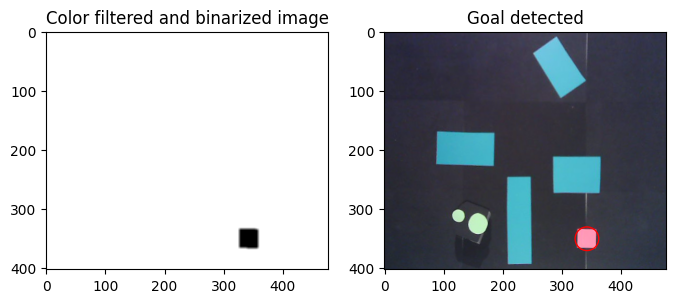

In [5]:
# Find goal function
_, _, filt_img = vision.colorFilter(rescMap,vision.RED_L,vision.RED_H)
goal_gray = cv2.cvtColor(filt_img, cv2.COLOR_BGR2GRAY)
goal_binary = cv2.threshold(goal_gray, 20, 255, cv2.THRESH_BINARY_INV)[1]
goal_binary = cv2.GaussianBlur(goal_binary, (5,5), 5,5)
contours, _ = cv2.findContours(goal_binary.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Get the moments (the external frame is taken as one)
mu = [None]*len(contours)
for i in range(len(contours)):
    mu[i] = cv2.moments(contours[i])
# Get the mass centers
mc = [None]*len(contours)
for i in range(len(contours)):
    # add 1e-5 to avoid division by zero
    mc[i] = (mu[i]['m10'] / (mu[i]['m00'] + 1e-5), mu[i]['m01'] / (mu[i]['m00'] + 1e-5))

# take second one since frame is the first
goal_coords = [mc[1][0],mc[1][1]]

circle_goal = plt.Circle(goal_coords, 20, color='r', fill=False)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,6))
ax2.imshow(rescMap[:,:,::-1])
ax1.imshow(goal_binary, cmap='gray')
ax2.add_patch(circle_goal)
ax1.set_title('Color filtered and binarized image')
ax2.set_title('Goal detected')

### 1.3 Find obstacles coordinates
Again the rescaled image is first filtered with a color filter and then binarized. The obstacle contours are then extracted using the findContours function and approximated via approxPolyDP. Since the corners of the obstacles are the input to the path planning algorithm, the obstacles must be expanded  by at least half the size of the thymio.This is done by finding the bisector of each edge and placing the new corner along its direction. In the case of a rectangular obstacle, the point should be placed at about 0.7 x the thymio width. To have some margin, it was decided to place it one thymio width away from the actual corner. Since the obstacles may intercept each other after drawing the new extended contours, a solution proposed here: https://stackoverflow.com/questions/70222415/opencv-how-to-merge-near-contours-to-get-the-one-big-outest-contour ,  was used to obtain the largest outer contour of the merged obstacles. The corners are then found again using approxPolyDP. The results can be shown by running the following cell.
	 

Text(0.5, 1.0, 'Obstacles after expansion and merging')

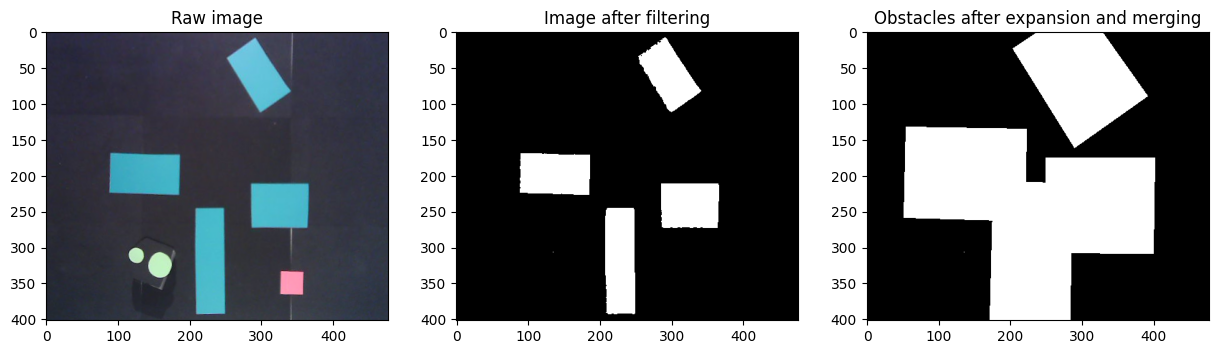

In [6]:
# Find obstacles function

hsv, mask, filt_img = vision.colorFilter(rescMap,vision.BLUE_L,vision.BLUE_H)
obst_gray = cv2.cvtColor(filt_img, cv2.COLOR_BGR2GRAY)
_, binary_img = cv2.threshold(obst_gray, 20, 10, cv2.THRESH_BINARY)
# find contours of obstacles
contours, _ = cv2.findContours(binary_img.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
approx_array = []
# approximate the contour with approxPolyDP
for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.03 * cv2.arcLength(cnt, True), True)
        area = cv2.contourArea(approx) # keep only the obstacles that have expected area (if filter would have a problem)
        if 3000 < area < 20000:
            approx_array.append(approx.reshape(-1, 2))
    
# Expand the contours
exp_cnt = np.copy(approx_array)
for i, cnt in enumerate(approx_array): # loop over obstacles
    for j, corner in enumerate(cnt): # loop over corners of obstacle
        e1 = cnt[(j-1)%cnt.shape[0]]-corner # find neighbors e1 and e2
        e2 = cnt[(j+1)%cnt.shape[0]]-corner
        bisector = (e1 / np.linalg.norm(e1) + e2 / np.linalg.norm(e2))
        exp_cnt[i][j] = corner - (vision.pix_per_mm*vision.THYMIO_WIDTH) * bisector / np.linalg.norm(bisector)

exp_img = cv2.drawContours(binary_img.copy(), exp_cnt, -1, 255, thickness=cv2.FILLED)
# Merge obstacles that intersects
h, w = exp_img.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(exp_img, mask, (0,0), 123)
exp_img = cv2.inRange(exp_img, 122, 124)
exp_img = cv2.bitwise_not(exp_img)
# https://stackoverflow.com/questions/70222415/opencv-how-to-merge-near-contours-to-get-the-one-big-outest-contour
contours_exp, _ = cv2.findContours(exp_img.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
approx_array_exp = []
# Re-approximate the polygones
for cnt in contours_exp:
    approx = cv2.approxPolyDP(cnt, 0.03 * cv2.arcLength(cnt, True), True)
    area = cv2.contourArea(approx)
    if 3000 < area < 80000:
        approx_array_exp.append(approx.reshape(-1, 2))


exp_img_app = cv2.drawContours(exp_img.copy(), approx_array_exp, -1, 255, thickness=cv2.FILLED)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,8))
ax1.imshow(rescMap[:,:,::-1])
ax2.imshow(binary_img, cmap='gray')
ax3.imshow(exp_img, cmap='gray')
ax1.set_title('Raw image')
ax2.set_title('Image after filtering')
ax3.set_title('Obstacles after expansion and merging')


### 1.4 Find Thymio
As with the obstacles and the goal, color filtering is first used to isolate the Thymio. Two green circles (a small one at the front and a large one between the two wheels) are taped on the Thymio. By finding the two circles, it is then possible to first extract the position of the Thymio at the wheel, i.e the large circle, and then by constructing a vector from the large circle to the small circle, it is possible to compute the angle of the Thymio. Blob detection was used to extract the center of the two circles and differentiate them from each other. The code below shows the results.

Text(0.5, 1.0, 'Image after filtering')

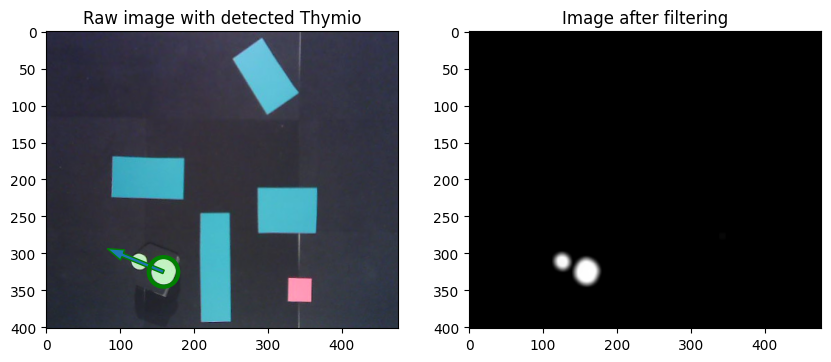

In [7]:
# Find thymio function

_, _, thymio = vision.colorFilter(rescMap, vision.GREEN_L, vision.GREEN_H)
thymio_gray = cv2.cvtColor(thymio, cv2.COLOR_BGR2GRAY)
thymio_gray = cv2.GaussianBlur(thymio_gray, (9,9), 5,5)
# Set up the blob detector 
params = cv2.SimpleBlobDetector_Params()
params.filterByColor = False
params.minThreshold = 100
params.maxThreshold = 255
params.filterByArea = True
params.minArea = 70
params.filterByCircularity = True
params.minCircularity = 0.6
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
keypoints = detector.detect(thymio_gray)
# Make sure only two rounds were found. If not --> vision failed and make position and angle nan
if len(keypoints) != 2:
    posX = np.nan
    posY = np.nan
    angle = np.nan
else:
    pts = cv2.KeyPoint_convert(keypoints)
    if keypoints[0].size > keypoints[1].size:
        [posX, posY] = pts[0] # Big round coordinates
        [SRx, SRy] = pts[1] # Small round coordinates
        dx = SRx-posX
        dy = -(SRy-posY)
        angle = m.atan2(dy,dx)
    else:
        [posX, posY] = pts[1]
        [SRx, SRy] = pts[0]
        dx = SRx-posX
        dy = -(SRy-posY)
        angle = m.atan2(dy,dx)
pos = [posX,posY]

circle_BR = plt.Circle(pos, 20, color='g', fill=False, linewidth=3)
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,8))
ax1.imshow(rescMap[:,:,::-1])
ax2.imshow(thymio_gray, cmap='gray')
ax1.arrow(pos[0], pos[1], 60*m.cos(angle), - 60*m.sin(angle), width = 5.0, ec = 'green')
ax1.add_patch(circle_BR)
ax1.set_title('Raw image with detected Thymio')
ax2.set_title('Image after filtering')

# 2. Global navigation

We choosed to use visibility graphs, we then apply a shortest path algorithm (A*). For this purpose, a Global_Navigation class is implemented.

In [8]:
import math
class Global_Navigation:
    def __init__(self,obstacles_pos,thymio_pos,goal_pos,map_size):            
        #convert the obstacle_pos as list of lists of tuples instead list of np.ndarray of tuples for next calculations
        self.all_obstacles=[]
        for index, obstacle in enumerate(obstacles_pos):
            self.all_obstacles.append([])
            for point in obstacle:
                self.all_obstacles[index].append((point[0],point[1]))
            
        self.raw_obstacles_pos=obstacles_pos
        self.thymio_pos=(thymio_pos[0],thymio_pos[1])
        self.goal_pos=(goal_pos[0],goal_pos[1])
        self.all_nodes=[]
        self.all_nodes.append(self.thymio_pos)
        self.all_nodes.append(self.goal_pos)      
        for obstacle in self.all_obstacles:
            for node in obstacle:
                self.all_nodes.append((node[0],node[1]))
        
        self.max_valx=map_size[0]
        self.max_valy=map_size[1]
        self.nodes_neigbors={}
        self.path=[]
        
globNav =Global_Navigation(obst_coords,t_coords,goal_coords,mapSize)

NameError: name 'obst_coords' is not defined

The objects of this class take as parameters the state of the map: the position of the thymio, the goal and the obstacles which have already been virtually extended to ensure that the thymio does not collide with the obstacles, and the size of the map.

### 2.1 Visibility graph

First of all, in order to create a visibility graph, we define: the position of the thymio, 
the goal and the vertices (which are not too close to the edges of the map) of the obstacles as nodes of the graph.

Then we construct links between the nodes that are not obstructed by obstacles.
To do so we distinct two cases: <br />
-create links between nodes that are not vertices of the same obstacle; <br />
-create links between nodes that are vertices of the same obstacle. <br />

##### Nodes that are not vertices of the same obstacle

In [ ]:
def onSegment(self,p, q, r):
    if ( (q[0] <= max(p[0], r[0])) and (q[0] >= min(p[0], r[0])) and 
           (q[1] <= max(p[1], r[1])) and (q[1] >= min(p[1], r[1]))):
        return True
    return False

Global_Navigation.onSegment = onSegment

def orientation(self,p, q, r):
    # to find the orientation of an ordered triplet (p,q,r)
    # function returns the following values:
    # 0 : Collinear points
    # 1 : Clockwise points
    # 2 : Counterclockwise
    val = (float(q[1] - p[1]) * (r[0] - q[0])) - (float(q[0] - p[0]) * (r[1] - q[1]))
    if (val > 0):
        # Clockwise orientation
        return 1
    elif (val < 0):
        # Counterclockwise orientation
        return 2
    else:
        # Collinear orientation
        return 0

Global_Navigation.orientation = orientation
  
def doIntersect(self,p1,q1,p2,q2):

    # Find the 4 orientations required for 
    # the general and special cases
    o1 = self.orientation(p1, q1, p2)
    o2 = self.orientation(p1, q1, q2)
    o3 = self.orientation(p2, q2, p1)
    o4 = self.orientation(p2, q2, q1)

    # General case
    if ((o1 != o2) and (o3 != o4)):
        return True
    # Special Cases

    # p1 , q1 and p2 are collinear and p2 lies on segment p1q1
    if ((o1 == 0) and self.onSegment(p1, p2, q1)):
        return True

    # p1 , q1 and q2 are collinear and q2 lies on segment p1q1
    if ((o2 == 0) and self.onSegment(p1, q2, q1)):
        return True

    # p2 , q2 and p1 are collinear and p1 lies on segment p2q2
    if ((o3 == 0) and self.onSegment(p2, p1, q2)):
        return True

    # p2 , q2 and q1 are collinear and q1 lies on segment p2q2
    if ((o4 == 0) and self.onSegment(p2, q1, q2)):
        return True

    # If none of the cases
    return False

Global_Navigation.doIntersect = doIntersect

For each pair of two nodes, we look to see if any edges of all obstacles prevent the creation of a link between the nodes in that pair.
To do this, in the implementation of this algorithm, the above code for segment intersection detection uses the functions of geeksforgeeks https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/ , which are based on the orientations of three given points in a certain order. If there is an intersection, no link is created, and we look for the feasibility of a link between the next pair of nodes.

##### Nodes that are vertices of the same obstacle

For nodes that are vertices of the same obstacle, looking at intersections does not work as we can see in the following example:

<img src="img_presentation/imageglobnav1.png" width="300"/>

We can see in the figure above that the segment formed by the two nodes specified by the red circles does not intersect with any other segment, however the thymio obviously cannot move from one to the other because the obstacle lies between them, hence the need to use another method for this case.

![second image global nav](img_presentation/imageglobnav2.png)

The figure above all possible orientations of: <br />
-the node 1, the node 2, and the node before the node 1 in the obstacle list (the vertices of the obstacle are sorted in the corresponding so their index are following the exterior contour in a "counter-clockwise" fashion);  <br />
-the node 1, the node 2, and the node after the node 1 in the list of the obstacle;  <br />
-the node 1, the node after the node 1 in the list of the obstacle, and the node before the node 1 in the list of the obstacle. <br />

(Note that we can define node 1 and node 2 interchangeably, regardless of whether they are simply the nodes of the pair of nodes whose feasibility we want to check for a link.)  <br />

In the figure above, we can easily deduce the combination of the three orientations leading to the impossibility of creating a link for the pair of nodes (the obstacle is between the two nodes) corresponding to the 4 cases in the first row of the figure above, which is implemented in the following function "find_neighbors".

It is enough to look at the orientation between the gray line and the direct neighboring vertices, because if we are in the cases of the second line of the figure above, and if it happens that other edges cross the gray line, this will be detected by the segment intersection function seen before, so no connecting line between the pair of nodes will be created. In cases where some of the 3 orientations searched for are collinear, this will also be handled by the segment intersection function.

In [ ]:
def find_neighbors(self,all_obstacles,all_nodes,pos_thymio,goal):


    neighbors = {node: [] for node in all_nodes}


    #if the nodes of obstacles are too close from the edges of the maps, don't add them to the visiblity graph
    nodes_close_edges=[]
    for obstacle in all_obstacles:
        for node in obstacle:
            if (node[0]< 38) or (node[0]> self.max_valx-38) or (node[1]<38) or (node[1]>self.max_valy-38):
                nodes_close_edges.append(node)
                
    for i in range(len(all_nodes)): 
        if all_nodes[i] in nodes_close_edges:
            continue
        for j in range(len(all_nodes) - i - 1):

            intersection=False

            if all_nodes[i+j+1] in nodes_close_edges:
                continue

            tmp_link1=[all_nodes[i],all_nodes[i+j+1]]

            for obstacle in all_obstacles:

                #identify when 2 vertices of the same polygon are connected
                if (all_nodes[i] in obstacle) and (all_nodes[i+j+1] in obstacle): 
                    if obstacle.index(all_nodes[i])==len(obstacle)-1:
                        if (obstacle.index(all_nodes[i+j+1]) != 0) and (obstacle.index(all_nodes[i])!=obstacle.index(all_nodes[i+j+1])+1):
                            o1=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[obstacle.index(all_nodes[i])-1])
                            o2=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[0])
                            o3=self.orientation(all_nodes[i],obstacle[0],obstacle[obstacle.index(all_nodes[i])-1])
                            if (o1==1 and o2==2)or (o1==o2 and o3==2):
                                intersection=True
                                break
                    elif obstacle.index(all_nodes[i])==0:
                        if (obstacle.index(all_nodes[i+j+1]) != len(obstacle)-1) and (obstacle.index(all_nodes[i+j+1]) != obstacle.index(all_nodes[i])+1):
                            o1=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[len(obstacle)-1])
                            o2=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[obstacle.index(all_nodes[i])+1])
                            o3=self.orientation(all_nodes[i],obstacle[obstacle.index(all_nodes[i])+1],obstacle[len(obstacle)-1])
                            if (o1==1 and o2==2)or (o1==o2 and o3==2):
                                intersection=True
                                break
                    else:
                        if (obstacle.index(all_nodes[i])!=obstacle.index(all_nodes[i+j+1])+1) and (obstacle.index(all_nodes[i+j+1]) != obstacle.index(all_nodes[i])+1):
                            o1=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[obstacle.index(all_nodes[i])-1])
                            o2=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[obstacle.index(all_nodes[i])+1])
                            o3=self.orientation(all_nodes[i],obstacle[obstacle.index(all_nodes[i])+1],obstacle[obstacle.index(all_nodes[i])-1])
                            if (o1==1 and o2==2)or (o1==o2 and o3==2):
                                intersection=True
                                break   

                #implement the segment intersection function between the current pair of nodes and all the edges of all the obstacles
                for index, vertice in enumerate(obstacle):

                    if index== len(obstacle)-1: #last point of the obstacle
                        tmp_link2=[(vertice[0],vertice[1]),(obstacle[0][0],obstacle[0][1])]
                    else:

                        tmp_link2=[(vertice[0],vertice[1]),(obstacle[index+1][0],obstacle[index+1][1])]


                    if tmp_link1[0] ==tmp_link2[0] or tmp_link1[0] ==tmp_link2[1] or tmp_link1[1] == tmp_link2[0] or tmp_link1[1] ==tmp_link2[1]:
                        continue

                    if self.doIntersect(tmp_link1[0],tmp_link1[1],tmp_link2[0],tmp_link2[1]):
                        intersection=True
                        break

                if intersection==True:
                    break

            if intersection==False:
                neighbors[all_nodes[i]].append(all_nodes[i+j+1])
                neighbors[all_nodes[i+j+1]].append(all_nodes[i])

    return neighbors

Global_Navigation.find_neighbors = find_neighbors

### 2.2 Find the shortest path

The A* algorithm is implemented because, compared to the Dijkstra algorithm, it is much faster and requires visiting far fewer nodes in the graph to find the correct path.

In [ ]:
def h_vertices_obstacles(self,coords,goal):
    k=[]
    for vertex in coords:
        k.append(math.dist(vertex,goal))
        h = dict(zip(coords, k))
    return h

Global_Navigation.h_vertices_obstacles = h_vertices_obstacles

The above function is responsible for defining the heuristic function as the distance between the graph nodes and the goal.

In [ ]:
def reconstruct_path(self,cameFrom, current):

    total_path = [current] 

    while current in cameFrom.keys():

        total_path.insert(0, cameFrom[current])  
        current=cameFrom[current]

    return total_path

Global_Navigation.reconstruct_path = reconstruct_path

The function above return the list of nodes to go to a certain node from the goal, used to get the path to the goal in the A* algorithm.

In [ ]:
def A_Star(self,start, goal, h_vertices_obstacles, coords, nodes_neigbors,max_valx,max_valy):


    for point in [start, goal]:
        assert point[0]>=0 and point[0]<max_valx and point[1]>=0 and point[1]<max_valy ,"start or end goal not contained in the map"


    openSet = [start]

    closedSet = []

    cameFrom = dict()

    gScore = dict(zip(coords, [np.inf for x in range(len(coords))])) 
    gScore[start] = 0 

    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = math.dist(goal,start)



    while openSet != []: 
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet 

        if current == goal:
            return self.reconstruct_path(cameFrom, current)

        openSet.remove(current)
        closedSet.append(current)

        for neighbor in nodes_neigbors[current]: 


            if (neighbor in closedSet): 
                continue


            tentative_gScore = gScore[current] + math.dist(current,neighbor) 

            if neighbor not in openSet:
                openSet.append(neighbor) 

            if tentative_gScore < gScore[neighbor]:
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h_vertices_obstacles[neighbor]


    print("No path found to goal")
    return [], closedSet

Global_Navigation.A_Star = A_Star

The A* is implemented in the above function, the weight to travel from one node to another is the distance between these two nodes.

In [ ]:
def create_path(self):           
    self.nodes_neigbors=self.find_neighbors(self.all_obstacles,self.all_nodes,self.thymio_pos,self.goal_pos)

    self.path=self.A_Star(self.thymio_pos, self.goal_pos, self.h_vertices_obstacles(self.all_nodes,self.goal_pos), self.all_nodes,self.nodes_neigbors ,self.max_valx,self.max_valy)
    return self.path

Global_Navigation.create_path = create_path
globNav.create_path()

[(158.54558, 325.1615),
 (51, 259),
 (54, 133),
 (222, 136),
 (289, 162),
 (401, 176),
 (399, 309),
 (342.5340757116392, 349.82105264402605)]

The above function is the one that allows to get the shortest path after initializing an object of the Global_Navigation class.

### 2.3 Plots

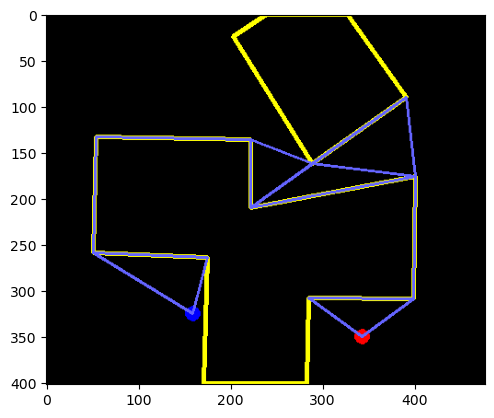

In [ ]:
def plot_visibility_graph(self):
    Img=np.zeros((self.max_valy, self.max_valx,3), dtype='uint8')

    for obstacle in self.raw_obstacles_pos:
        cv2.polylines(Img, [obstacle.reshape((-1, 1, 2))], True, (255,255,0), 3) 

    cv2.circle(Img, (round(self.goal_pos[0]),round(self.goal_pos[1])), 5, (255, 0, 0), 5)
    cv2.circle(Img, (round(self.thymio_pos[0]),round(self.thymio_pos[1])), 5, (0, 0, 255), 5)

    for node in self.nodes_neigbors:
        for neighbor in self.nodes_neigbors[node]:
            image = cv2.line(Img, (round(node[0]),round(node[1])), (round(neighbor[0]),round(neighbor[1])), (100, 100, 255), 2)
    plt.imshow(image) 
    
Global_Navigation.plot_visibility_graph = plot_visibility_graph
globNav.plot_visibility_graph()

The blue circle is the position of the Thymio, the red circle the position of the goal. We can notice on the figure above that no link is created for the vertices of the obstacles which are too close to the edges of the map, because the thymio cannot go towards these nodes.

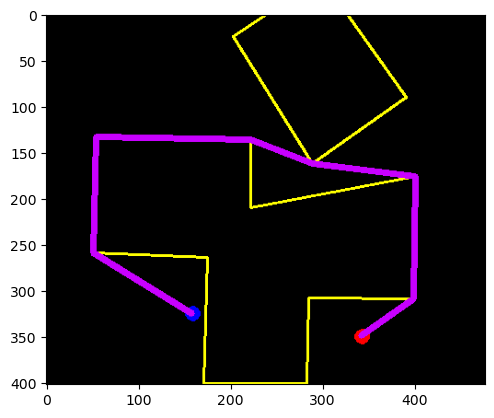

In [ ]:
def plot_shortest_path(self):
    Img=np.zeros((self.max_valy, self.max_valx,3), dtype='uint8')
    for obstacle in self.raw_obstacles_pos:
        image = cv2.polylines(Img, [obstacle.reshape((-1, 1, 2))], True, (255,255,0), 2) 
    cv2.circle(Img, (round(self.goal_pos[0]),round(self.goal_pos[1])), 5, (255, 0, 0), 5)
    cv2.circle(Img, (round(self.thymio_pos[0]),round(self.thymio_pos[1])), 5, (0, 0, 255), 5)

    cv2.polylines(Img, np.int32([np.array(self.path).reshape((-1, 1, 2))]), False, (200, 0, 255), 5) 

    plt.imshow(image)
    
Global_Navigation.plot_shortest_path = plot_shortest_path
globNav.plot_shortest_path()

The purple line represents the shortest path from the position of the Thymio, to the goal.

# 3. Motion Control

For motion control, we used a PID controller that was used to smooth the robot trajectory. This PID controller works on the angle error between the robot direction and the goal direction. A PI controller would probably have been sufficient but we decided to use a PID to have more freedom for tuning.

This PID controller compares the angle error and gives a delta 'rotation' speed as output. This rotation speed will then be added/substantiated to the speed of the left and right motors. To get something, see below :
<div>
<img src="img_presentation/pid_resume.png" width="300"/>
</div>

For the computation of the angle error, we need the following information:
- robot position
- robot angle
- position of the goal

We represent the position in classical cartesian coordinates (x,y). The angle of the thymio(alpha) and the angle of the goal(alpha_goal) are 'absolute angles'. The vector (1,0) has the angle 0 (the vector (0,1) as the angle pi/2 etc...). The angle is negative clockwise. The angle error is always represented in the range: [-pi , pi], In this way, the PID controller is easy to implement. The image below shows the general idea of the PID implementation:

<div>
<img src="img_presentation/PID_details.png" width="500"/>
</div>

The motion control part is done in a class in the .py file. For more information, see the script: functiion.MotionControl.py.

In [ ]:
import function.MotionControl as MotionControl
import matplotlib.pyplot as plt
import math

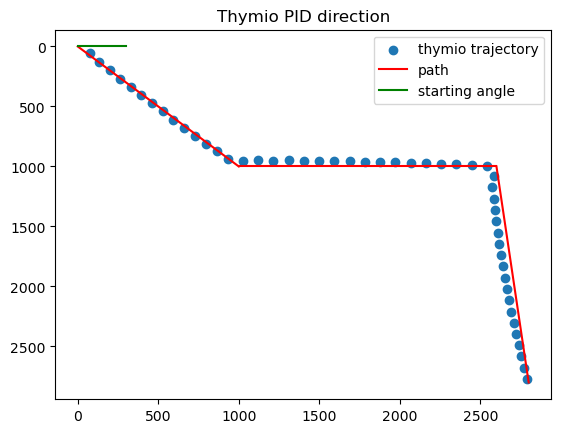

In [ ]:
# Here is an exemple trajectory of the implemetation of the PID without the filtered feedback about the position and angle.
# For this exemple, we take only the 
# Here is an exemple trajectory of the implemetation of the PID without the filtered feedback about the position and angle.
# For this exemple, we take only the 

goals_list = [(1000,1000), (2600,1000),(2800,2800)]
n_goal = 0
goal_pos = list(goals_list[n_goal])

init_robot_angle = 0
robot_speed = [100,100]
robot_angle = 0
robot_pos = [0,0]

d_time = 3
thymio_trajectory = []

# Create PID controller
PID = MotionControl.MotionControl()
PID.update_angle_error(robot_angle, robot_pos, goals_list[n_goal])
# loop
loop = 0
while True:
    loop += 1
    goal_achieved = False
    # compute error
    PID.update_angle_error(robot_angle, robot_pos, goal_pos)
    # compute PID speed
    [robot_speed[0], robot_speed[1]] = PID.PID(d_time, 100, 100)
    # set speed and get new position and angle value
    [robot_pos[0], robot_pos[1], robot_angle] = PID.plant(robot_speed[0], robot_speed[1], robot_pos[0], robot_pos[1], robot_angle, d_time)
    thymio_trajectory.append((robot_pos[0], robot_pos[1]))
    
    # Check proximity
    dist_to_goal = math.sqrt((robot_pos[0]-goal_pos[0])**2 + (robot_pos[1]-goal_pos[1])**2)
    if dist_to_goal < 100 or loop > 300:
        n_goal += 1
        if n_goal < len(goals_list):
            goal_pos = list(goals_list[n_goal])
            # reset integral value
            PID.PID_integral = 0
        else:
            break

# plot trajectorie
ax = plt.gca()
ax.invert_yaxis()
plt.scatter(*zip(*thymio_trajectory), label='thymio trajectory')

# Plot objective 'path'
plt.plot([0,goals_list[0][0]], [0,goals_list[0][1]], color = 'red', linestyle = 'solid', label='path')

plt.plot([goals_list[0][0],goals_list[1][0]], [goals_list[0][1],goals_list[1][1]], color = 'red', linestyle = 'solid', label=None)
plt.plot([goals_list[1][0],goals_list[2][0]], [goals_list[1][1],goals_list[2][1]], color = 'red', linestyle = 'solid', label=None)

plt.plot([0,300*math.cos(init_robot_angle)], [0, 300 * math.sin(init_robot_angle)], color = 'green', label='starting angle')

plt.legend()
plt.title('Thymio PID direction')
plt.show()



# 4. Filtering

The filter helps to have a better approximation of the thymio position. For this we will take the position given by the odometry and the position given by the camera and use a fitler. The filter we use is inspired by the Kalmann filter but is a little different because the calculation of the estimated position is done in the odometry filter and not in the filter. 

The filtering is composed of 2 filters. The first one filters the position by comparing the odometry position with the position given by the vision.
The second filter does the same thing but comparing the angle. The combination of these 2 filters gives us an approximation on all important variables.

Once the filtering has finished its calculation, we gave the new values of the position and angle to the global variable ODOMETRY. In this way, ODOMETRY always has the best approximation and the error does not increase with time (to be more precise, the error increases with time until the filtering gives new values. But since the filtering is often computed, this is not a problem). With this technique we also solve the kidnapping problem, i.e. we can move the robot to any location and the odometry will be updated to track the robot again. Also, when the wheels skid, we do not lose track of the robot.

Below is a representation of the position estimated by the thymio before and after filtering:

In [ ]:
# Here we present the estimated postition of the thymio before and after the filtering. For this we have recorded the estimeted postiton of the thymio.
import json
with open('img_presentation/ODOMETRY.txt', 'r') as f:
    LIST_ODO = json.loads(f.read())

import numpy as np
thymio_traj_points=np.array([np.array(x[0:2]) for x in LIST_ODO])
thymio_traj_points = np.transpose(thymio_traj_points)
thymio_traj_points

array([[ 65.63349917,  65.63349917,  65.63349917, ..., 391.00675674,
        391.9058683 , 392.6495354 ],
       [320.05721393, 320.05721393, 320.05721393, ..., 219.16560627,
        219.38248831, 219.56155774]])

In [ ]:
plt.title('Full recorded thymio trajectory')
plt.scatter(thymio_traj_points[0],thymio_traj_points[1], color='blue')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# here we will highlight the moment the filter is going to recompute the thymio postion
plt.figure(1,figsize=(10,4))

plt.subplot(121)
thymio_traj_points_ = thymio_traj_points[:,130:150]
plt.title('Highlighting filtering correction')
plt.scatter(thymio_traj_points_[0],thymio_traj_points_[1])

plt.subplot(122)
thymio_traj_points_ = thymio_traj_points[:,140:148]
plt.title('Highlighting filtering correction')
plt.scatter(thymio_traj_points_[0],thymio_traj_points_[1])


plt.show()

# We can see on near the region [137,252] 2 points being close to eachother. 
# we have here the filtering recomputing a better position for the thymio

In [ ]:
# Here is another place where the filtering can be seen
thymio_traj_points_ = thymio_traj_points[:,350:400]
plt.title('Highlighting filtering correction')
plt.scatter(thymio_traj_points_[0],thymio_traj_points_[1])
plt.show()


NameError: name 'thymio_traj_points' is not defined

On the previous graph we can see some position adjustement due to the filtering.
<div>
<img src="img_presentation/filter_results_2.png" width="400" />
</div>

# 5. Local Navigation

The objective of local navigation is that the Thymio avoids new obstacles placed on its path.

We decided to use the artificial neural network (ANN) approach.

First, a function is used to detect the obstacles using horizontal proximity sensors because the new obstacles are in three dimensions.


In [ ]:
def detect_obstacle(self, proximity_sensors, threshold=100):  
    self.prox_horizontal = proximity_sensors[0:4] 
    maxvalue = max(self.prox_horizontal)
    if(maxvalue > threshold) : 
        detect = True
    else :
        detect = False
    return detect


When the horizontal proximity sensors detect an obstacle, we calculate the speed of the motors so that the robot turns and is no longer in front of the obstacle. 

Artificial Neural Networks are a good approach for this purpose because, depending on the distance to the obstacle and the values of the proximity sensors, the robot will adapt its rotation speed and time to perform one of the most optimal trajectories to bypass the obstacle.

The weights were set experimentally.


In [ ]:
def turn_if_obstacle(self, proximity_sensors): 
    self.prox_horizontal = proximity_sensors[0:4] 
    w_l = [20,  30, -30, -30, -20]
    w_r = [-20, -30, 30,  30,  20]

    # Scale factors for sensors 
    sensor_scale = 400

    y = [0,0]
    x = [0,0,0,0,0]
    

    
    for i in range(0,len(x)-1):
        # Get and scale inputs
        x[i] = self.prox_horizontal[i] // sensor_scale
        
        # Compute outputs of neurons and set motor powers
        y[0] = y[0] + x[i] * w_l[i]
        y[1] = y[1] + x[i] * w_r[i]    

    # Set motor powers
    motor_left_target = y[0]
    motor_right_target = y[1]

    return [motor_left_target,motor_right_target]


Then the robot follows a curvilinear path in the direction of the goal. 

This is done by setting a lower speed for the wheel closest to the obstacle. 


In [ ]:
def curvilinear_traj(self, speeds) :
    NOMINAL_SPEED = 160
    DELTA_SPEED = 60
    if(speeds[0]<speeds[1]) :
        motor_left_target = NOMINAL_SPEED
        motor_right_target = NOMINAL_SPEED - DELTA_SPEED
    else :
        motor_left_target = NOMINAL_SPEED - DELTA_SPEED
        motor_right_target = NOMINAL_SPEED

    return [motor_left_target,motor_right_target]

When the robot is far enough away from the obstacle, it returns to the main loop, to recalculate the new trajectory in order to get to the next point of the trajectory (see section 'Threading and code organization').

# 7. Threading and code organization
### 7.1 Threads and odometry
We decided to use a wire for the data acquisition of the thymio. This way, we don't need to wait for the thymio to get the information about the speed of the thymio and the sensors. These calculations can be done in parallel in order to be able to calculate simultaneously the vision and the motion control. 

The two threads we have created are the following:
- thread_update_odometry 
- thread_get_sensor

The odometry thread takes the speed values of the motors and calculates the relative position/angle of the thymo. It then returns the results in the global variable ODOMETRY. This way, this global variable will be updated and can be reused in other threads for other calculations.


The get sensor thread is a simpler thread that only reads the sensor values and also returns them in a global variable (PROX_SENSOR). 

This way we have two global variables that are updated and accessible at any time.

We decided to use threads, because reading the sensor variables can take up to 100 ms. If we had a thread in a simple loop, the whole program would be waiting for the sensor values.
The main thread is the loop in the main file. In this part we calculate the following parts: visualization, filtering and the controller.


<div>
<img src="img_presentation/threads_.png" width="500"/>
</div>

##### Odometry 
The odometry part is a thread in the following file: function/main.py.


As said before, we calculate and update the odometry in a thread and the result is stored in a global variable. Another thing to note is that this global variable ODOMETRY is also updated after the filtering. This means that this ODOMETRY variable does not only depend on the motor speed but is also modified by the vision. With this technique, the error of the odometry does not increase over time (this is the case when the odometry runs alone but is adjusted as soon as it enters the filtering).

Now, let's look at the thread update odometry in detail. The goal here is to estimate the position of the robot by knowing the speed of the right and left motors. To do this, we made the following calculations and assumptions:

<div>
<img src="img_presentation/odometry.png" width="800" />
</div>


This odometry calculation is based only on the speed of the right and left motors. We therefore have an error on the prediction of the posture which comes from the imperfect values of the speed of the motors. To correct this error, we will need a filter (for the moment, this error will increase with time because we are essentially integrating the speed). More information about this in the '4. Filtering' section.

### 7.2 Organization of the main
The main is executed at the same time as the threads.

It first performs the initialization of all the variables. It also starts the computer vision (see '7.3 Implementation of the computer vision in the main') and compute the optimal trajectory using the global navigation functions.

Then it goes in an infinite while loop and the motion control can begin. We go through the list of points given by the global navigation and the first point is set as the goal. As soon as this point is attained by the robot, the next point becomes the objective. As long as no obstacle is detected, the motors speed are set by the PID controller, which compute the angle of the robot necessary to attain the goal. Each 0.1 second the odometry and the computer vision gives two theoretical positions of the Thymio, which will go through a filter to get the estimated position. This position is used by the motion control to recompute the trajectory.

If an obstacle is detected, the local navigation functions are used to avoid it. As soon as the obstacle is far enough, we go back in the motion control part of the code, and Thymio's position will be recomputed to get the new trajectory to attain next point.


### 7.3 Implementation of the computer vision and simulation
As written before, the vision is first used to initialize the map and send all the coordinates necessary to plan the route. Once the Thymio is running, the vision is used in support of the odometry to estimate the position of the Thymio. Two main functions using the function presented above have been implemented. The first one, dedicated to the initialization of the map can be called from the main during the initialization and return all the necessary data. Once the thymio starts to move, it is not necessary to recalculate the position of the goal and the obstacle so the second function only rectifies the image and finds the thymio. The two functions can be called in the next two cells.

In [ ]:
import function.visualisation as visualisation
import time
shortestpath = []
rescMap, M, IMGwidth, IMGheight, mapSize, goal_coords, obst_coords, t_coords, t_angle = vision.map_init(img)
visualisation.visualisation(rescMap, t_coords[0], t_coords[1], obst_coords, t_angle, shortestpath, goal_coords[0], goal_coords[1])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
rescMap, t_coords, t_angle = vision.updateThymioPos(img, M, IMGwidth, IMGheight)
visualisation.visualisation(rescMap, t_coords[0], t_coords[1], obst_coords, t_angle, shortestpath, goal_coords[0], goal_coords[1])       
cv2.waitKey(0)
cv2.destroyAllWindows()

By executing the code below, you can test the vision on a few images of a recorded course. Once the initialization is done, you can start the "fake" thymio by pressing any key.

In [ ]:
# Need this loop when camera is on

i = 1
d1 = 100
d2 = 100
while 1:
    # Take first picture for init
    frame = cv2.imread('img_presentation/vision_run/run_0.png', cv2.IMREAD_COLOR)

    # Initialize MAP
    rescMap, M, MAPwidth, MAPheight, b_coords, goal_coords, obst_coords, t_coords, t_angle = vision.map_init(frame)
    visualisation.visualisation(rescMap, t_coords[0], t_coords[1], obst_coords, t_angle, shortestpath, goal_coords[0], goal_coords[1])
    cv2.waitKey(0) # Start the robot
    
    # Entering main loop (while thymio not in goal region)
    while d1 > 20 or d2 > 20:

        ########### Update Thymio Position and Angle ############
        # Capture new frame

        img_name = "img_presentation/vision_run/run_" + str(i) +".png"
        i +=1
        frame = cv2.imread(img_name, cv2.IMREAD_COLOR)
        ### Find Thymio
        rescMap, t_coords, t_angle = vision.updateThymioPos(frame, M, MAPwidth, MAPheight)
        visualisation.visualisation(rescMap, t_coords[0], t_coords[1], obst_coords, t_angle, shortestpath, goal_coords[0], goal_coords[1])       

        d1 = abs(t_coords[0]-goal_coords[0])
        d2 = abs(t_coords[1]-goal_coords[1])
        
        ########## Filtering should go here ############
        time.sleep(0.2)


        # Press esc on keyboard to  exit
        if cv2.waitKey(1) == 27:
            break
    break
time.sleep(1)
cv2.destroyAllWindows()

# Conclusion
This project gave us a better understanding of many concepts in the course.

The executable code is the main.py in the function folder.